In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table
import csv
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import emcee
import corner

In [2]:
data = Table.read("Dati.csv", format= "ascii" )

<ul>
    <li> ra e dec sono in gradi </li>
    <li> v_disp e v_disp_err sono in $\frac{km}{s}$ </li>
    <li> dered_u e dered_r sono in mag</li>
    <li> z non ha unità di musra</li>
    <li> lgm_tot_p84, 16 e 50 sono in Log solar masses </li>
    <li> deVRad_r ed deVRadErr_r in arcsec </li>
</ul>

In [3]:
data

<Table length=13853>
     ra           dec        dered_u  ... lgm_tot_p50 fracDeV_r objType
  float64       float64      float64  ...   float64    float64    str6 
------------ -------------- --------- ... ----------- --------- -------
 245.9279566     0.80728642 19.202175 ...    11.07006       1.0  GALAXY
 237.2497875 -0.00480858517 20.515705 ...   10.577079       1.0  GALAXY
154.99760507     0.32136994 20.133015 ...   10.564025       1.0  GALAXY
168.68449007     0.34369823 19.577206 ...   10.939172       1.0  GALAXY
173.35111343     2.22009454  19.86113 ...   10.723038  0.993598  GALAXY
146.97878272     2.04276947 21.687792 ...   10.733129  0.964726  GALAXY
159.32648659     2.26184009  18.91678 ...    11.07223       1.0  GALAXY
173.53777151     2.56266652 19.456171 ...   10.760537       1.0  GALAXY
174.13569691      3.4795274 20.038715 ...   10.636981       1.0  GALAXY
154.30432938    -0.25885795 19.610228 ...   10.653419       1.0  GALAXY
         ...            ...       ... ...         ...       ...     ...
   164.50132    21.19371684 19.720749 ...   10.996307       1.0  GALAXY
170.92697524    19.76815594 19.635141 ...   10.745266       1.0  GALAXY
236.83399813     13.0198014 19.619276 ...   10.901249       1.0  GALAXY
141.72583869    15.06221754 19.608725 ...   10.878257       1.0  GALAXY
206.21823441    17.91569303 19.761971 ...   10.908792       1.0  GALAXY
214.71921387    17.70936935 18.717533 ...   11.106627       1.0  GALAXY
209.29421181    15.95409682 19.961439 ...   10.794777       1.0  GALAXY
211.06110559    14.75078185 19.566145 ...   10.873819       1.0  GALAXY
  246.262294     12.0793912  19.43091 ...   10.784704  0.965384  GALAXY
129.19118245     9.51777066 20.222633 ...   10.816586       1.0  GALAXY

In [4]:
ra = data['ra']
dec =  data['dec']
dered_u = data['dered_u']
dered_r = data['dered_r']
z = data['z']
Re = data['deVRad_r']
Err_Re = data['deVRadErr_r']
velDisp_kms = data['velDisp']
Err_velDisp_kms = data['velDispErr']
Log_mass84 = data['lgm_tot_p84']
Log_mass16 = data['lgm_tot_p16']
Log_mass50 = data['lgm_tot_p50']
fracDev = data['fracDeV_r']

In [5]:
#dered_u_grezzi = dered_u_grezzi[dered_u_grezzi > -100]
#dered_r_grezzi = dered_r_grezzi[dered_r_grezzi > -100]

spettro preso solo per mag minore di 18 circa. Le galassie si dispongono in due gruppi principali...uo un po piu allungato ed uno
gli oggetti in alto sono piu luminose sono pi rosse. "red sequence" quelli in alto. Gli oggietti piu in basso sono meno luminose e sono piu blu chiamti "blue clound". Green valley sono quelle in mezzo. Le galsassi spirali sono sul blu. QUelle ellittiche sul 
rosso. Tramite i colori possiamo indivuduare le nostre galassie ellittiche. 
Sono piu numerose le galassie a spirale. Stelle di tipo b sono molto calde e stanno in alto nel diagramma HR.
Settro tipico galassia ellittica---> spettro di assorbimento e le stelle piu calde (in basso in HR) hanno lo spettro simile.ik-_-


Quello che vogliamo fare è un fit della brillanza superficiale con de profili di luminosità diversi.
La brillanza superficiale 


# calcolo della frazione di massa.
Per il calcolo della frazione di massa, definita come <br>
$f_E(R_E) = \frac{M_{*}}{2 \cdot M_{tot}}$ <br>
con <br>
$M_{tot} = \frac{\pi \sigma^2}{G}R_E$ <br>
dove le quantità in gioco sono rispettivamente:<br>
<ul>
    <li> f_E(R_E) = Frazione di massa stellare, ovvero quante stelle ci sono in un certo raggio </li>
    <li> R_E è il raggio di metà luce, ovvero il parametro deVRad_r con incertezza deVRadErr_r. </li>
    <li> G è la costante di gravitazione universale e vale $6.67 \cdot 10^{-11} \frac{Nm^2}{kg^2}$ </li>
    <li> \sigma è la v_disp con incertezza v_disp_err e corrisponde alle velocità...??? </li>
</ul>

In [6]:
mass84 = 10**(Log_mass84)
mass16 = 10**(Log_mass16)
mass_galaxy = 10**(Log_mass50)
sigma_mass_galaxy = (mass84 - mass16)/2

In [7]:
data['mass_galaxy'] = mass_galaxy # ovviamente è in masse solari
data['sigma_mass_galaxy'] = sigma_mass_galaxy # anch'essa in masse solari
G = 6.67*1e-11 * 1.98*1e30 / (3.08 * 1e16)**3
velDisp = velDisp_kms/(3.08 * 1e13) #parsec su secondo
Err_velDisp = Err_velDisp_kms/(3.08 * 1e13) #parsec su secondo
R_e = 2.16 * 1e3 * Re # 
Sigma_Re = 2.16 * 1e3 * Err_Re

In [8]:
f_galaxy = (mass_galaxy * G) / (2*np.pi * velDisp**2 * R_e)
sigma_f_galaxy = np.sqrt((sigma_mass_galaxy/mass_galaxy)**2 + (2*Err_velDisp/velDisp)**2 + (Sigma_Re/R_e)**2)*f_galaxy

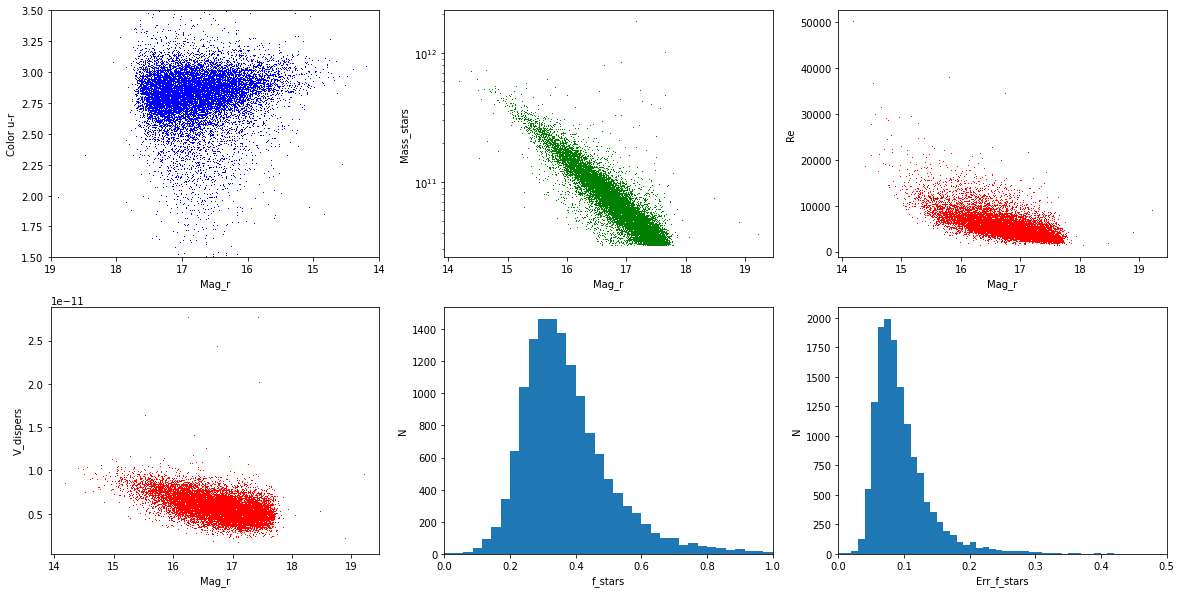

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(20,10));
color = dered_u - dered_r
axs[0,0].plot(dered_r, color,',', color = 'blue');
axs[0,0].invert_xaxis()
axs[0,0].set_xlim(19, 14)
axs[0,0].set_ylim(1.5, 3.5)
axs[0,0].set_xlabel("Mag_r")
axs[0,0].set_ylabel("Color u-r");

axs[0,1].plot(dered_r, mass_galaxy, ',', color = 'green') # si osserva che la relazione di proporzionalità tra la massa e la luminosità è cubica
axs[0,1].set_xlabel("Mag_r") # L prop M^39
axs[0,1].set_yscale('log')
axs[0,1].set_ylabel("Mass_stars");

axs[0,2].plot(dered_r, R_e, ',', color = 'red') # più re diventa grande piu la galassia è meno luminosa...non per forza è una codnzione 
axs[0,2].set_xlabel("Mag_r")
axs[0,2].set_ylabel("Re");

axs[1,0].plot(dered_r, velDisp, ',', color = 'red')
axs[1,0].set_xlabel("Mag_r")
axs[1,0].set_ylabel("V_dispers");

axs[1,1].hist(f_galaxy, bins = 70, range = (0,2));
axs[1,1].set_xlim(0, 1)
axs[1,1].set_xlabel("f_stars")
axs[1,1].set_ylabel("N");

axs[1,2].hist(sigma_f_galaxy, bins = 200, range = (0,2));
axs[1,2].set_xlim(0, 0.5)
axs[1,2].set_xlabel("Err_f_stars")
axs[1,2].set_ylabel("N");

In [10]:
f_DM = 1 - f_galaxy # frazione di Dark matter

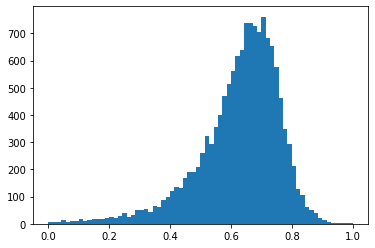

In [11]:
plt.hist(f_DM, bins = 70, range = (0,1)); # notare come rispecchia l'andamento di un corpo nero

# Definizione di likelihood

In [12]:
def sum_err(e_plx, sigma_cl):
    return sigma_cl**2 + e_plx**2

def loglikelihood(par, f_mis, Err_f_mis) :
    f,sigma_f = par
    err = sum_err(Err_f_mis, sigma_f)
    return np.sum(- 0.5*(np.log(2) + np.log(np.pi) + np.log(err)) - 0.5*(f_mis - f)**2 / (err))

f_min = 0
f_max = 1
Err_f_min = 0
Err_f_max = 1

def logprior(par):
    f,sigma_f = par
    if f < f_min or f > f_max or sigma_f < Err_f_min or sigma_f > Err_f_max:
        return -np.inf
    else:
        return -np.log((f_max - f_min)*(Err_f_max - Err_f_min))
    
def log_posterior (par, f_mis, Err_f_mis): 
    lp = logprior(par)
    if np.isfinite(lp):
        return lp + loglikelihood(par, f_mis, Err_f_mis)
    else:
        return lp

In [23]:
soln = [np.random.uniform (f_min, f_max), np.random.uniform(Err_f_min, Err_f_max)]
print(soln)
pos = soln + 1e-4 * np.random.randn(7, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(f_galaxy, sigma_f_galaxy))

sampler.run_mcmc(pos, 5000, progress=True);

[0.698339092707833, 0.15421813973806653]


100%|██████████| 5000/5000 [00:15<00:00, 326.64it/s]


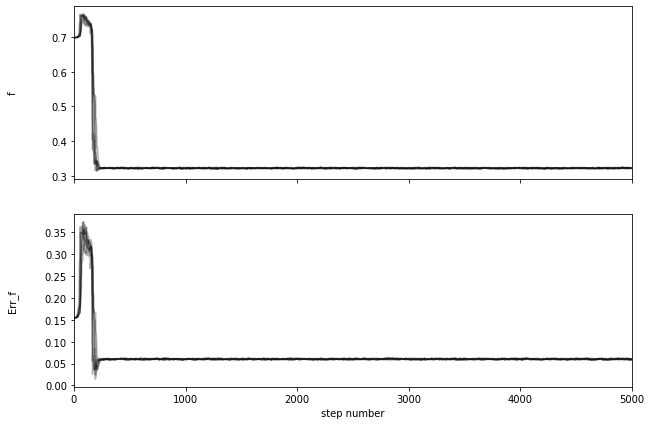

In [24]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["f", "Err_f"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [25]:
soln = [samples[4999,3,0], samples[4999,3,1]]
pos = soln + 1e-4 * np.random.randn(7, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(f_galaxy, sigma_f_galaxy))

sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [00:30<00:00, 330.25it/s]


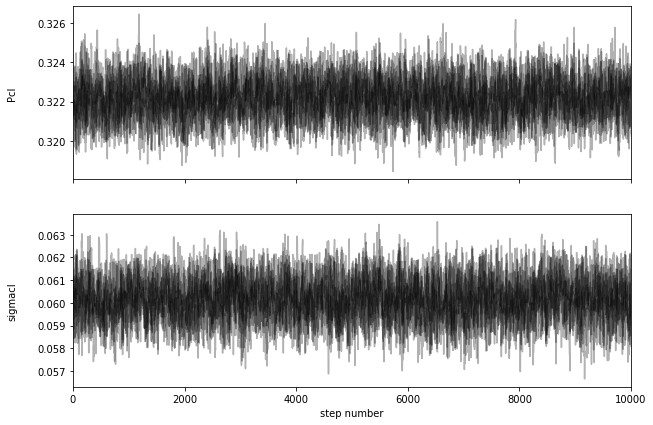

In [26]:
fig1, axes1 = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Pcl", "sigmacl"]
for i in range(ndim):
    ax1 = axes1[i]
    ax1.plot(samples[:, :, i], "k", alpha=0.3)
    ax1.set_xlim(0, len(samples))
    ax1.set_ylabel(labels[i])
    ax1.yaxis.set_label_coords(-0.1, 0.5)

axes1[-1].set_xlabel("step number");

In [27]:
flat_samples = sampler.get_chain(discard=100, thin=1, flat=True)
print(flat_samples.shape)

(69300, 2)


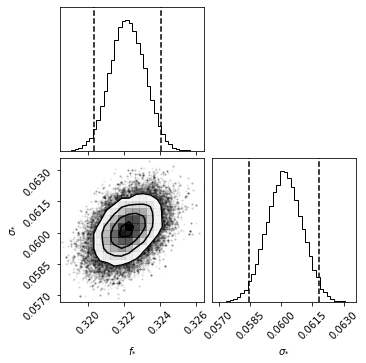

In [29]:
label = ['$f_{*}$', '$\sigma_{*}$']
fig = corner.corner(flat_samples, labels=label, title_fmt='.4f', quantiles = [0.025, 0.975],hist_bin_factor = 2);
plt.savefig("posterior.pdf")

In [30]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])

    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [31]:
flat_samples[:, 0] = 1 - flat_samples[:,0]  

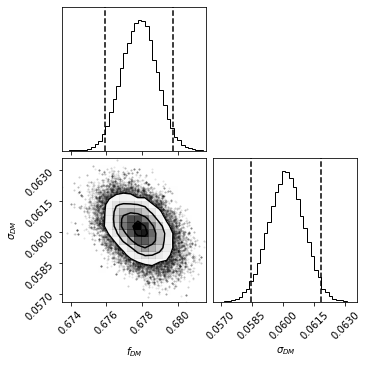

In [32]:
label = ['$f_{DM}$', '$\sigma_{DM}$']
figs = corner.corner(flat_samples, labels=label, quantiles = [0.025, 0.975], hist_bin_factor = 2);
plt.savefig("posterior.pdf")

In [33]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])

    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [ ]:
f_DM

In [ ]:
def selection_sort(x):
    for i in range(len(x)):
        swap = i + np.argmin(x[i:])
        (x[i], x[swap]) = (x[swap], x[i])
    return x

In [ ]:
f_DM_sort = selection_sort(f_DM)

In [ ]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.)/ (2 * np.power(sig, 2.)))

plt.plot(f_DM_sort, 2000*gaussian(f_DM_sort, 0.6779, 0.0601), marker = '.', color = 'r')
plt.hist(f_DM, bins = 300, histtype='step');
plt.xlim(0, 1.25)